# EP #4 - Object Recognition: BoF vs ConvNets

Renato Sérgio Lopes Júnior \
2020667570

In [1]:
import os
import cv2
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import sklearn
from sklearn.cluster import MiniBatchKMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

## Load CIFAR-10 dataset

In [2]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])

inv_normalize = transforms.Normalize(
    mean=[-1.0, -1.0, -1.0],
    std=[1/0.5, 1/0.5, 1/0.5]
)

def get_cv2_image(img):
    return cv2.cvtColor((inv_normalize(img).numpy().transpose(1, 2, 0) * 255).astype(dtype=np.uint8), cv2.COLOR_RGB2BGR)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

NUM_CLASSES = 10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


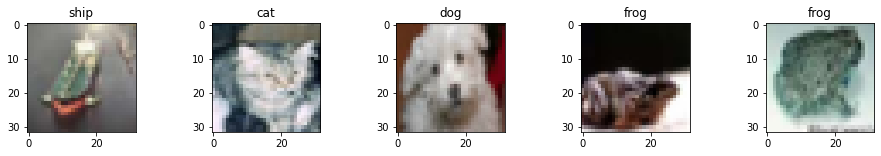

In [3]:
fig = plt.figure(figsize=(16,2))
for i in range(1, 6):
    X, y = trainset[np.random.randint(len(trainset))]
    img = get_cv2_image(X)
    plt.subplot(1, 5, i)
    plt.title(classes[y])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

## A classifier based on bag of features

### Extracting SIFT features

In [4]:
sift = cv2.SIFT_create(nfeatures=100)

def get_sift_features(dataset):
    sift_features = {i: [] for i in range(NUM_CLASSES)}

    # Get SIFT descriptions for all samples in dataset
    for i in range(len(dataset)):
        if ((i+1)/len(dataset)*100)%10 == 0:
            print(f"{(i+1)/len(dataset)*100}%")
        X, y = dataset[i]
        img = get_cv2_image(X)
        kp, des = sift.detectAndCompute(img, None)
        if des is None:
            continue
        sift_features[y].append(des)
    
    return sift_features

def get_descriptions_matrix(sift_features):
    # Returns matrix with SIFT descriptions (for clustering)
    descriptions = []
    for i in range(NUM_CLASSES):
        for j in range(len(sift_features[i])):
            descriptions.extend(sift_features[i][j])
    descriptions = np.array(descriptions)
    return descriptions

In [5]:
# Get SIFT descriptions for training samples
train_sift_features = get_sift_features(trainset)
train_descriptions = get_descriptions_matrix(train_sift_features)

# Get SIFT descriptions for test samples
test_sift_features = get_sift_features(testset)

10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
100.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
100.0%


### Create visual dictionary

In [6]:
def create_clustering(descriptions, dict_size):
    # Cluster descriptions
    clustering = MiniBatchKMeans(n_clusters=dict_size).fit(descriptions) # Use MiniBatchKMeans for better performance
    return clustering

def get_visual_dict(clustering, descriptions, dict_size):
    hist = np.zeros(dict_size)
    for desc in descriptions:
        word = clustering.predict(desc.reshape(1, -1))
        hist[word[0]] += 1
    cv2.normalize(hist, hist, norm_type=cv2.NORM_L2)
    return hist

def get_bof_data(clustering, sift_features, dict_size):
    X = []
    y = []
    # Get visual dictionary for each image
    for i in range(NUM_CLASSES):
        if ((i+1)/NUM_CLASSES*100)%10 == 0:
            print(f"{(i+1)/NUM_CLASSES*100}%")
        for j in range(len(sift_features[i])):
            bof = get_visual_dict(clustering, sift_features[i][j], dict_size)
            X.append(bof)
            y.append(i)
    return X, y

### Train Random Forest Classifier with Dictionary Size 8

#### Create Visual Dictionaries

In [7]:
DICT_SIZE = 8
# Create clustering
print("Creating cluster...")
clustering = create_clustering(train_descriptions, dict_size=DICT_SIZE)
print("Created cluster.")

# Get training data visual dictionaries
print("Getting visual dictionaries...")
bof_X, bof_y = get_bof_data(clustering, train_sift_features, dict_size=DICT_SIZE)
print("Got visual dictionaries.")

# Get visual dictionaries for test samples
print("Getting visual dictionaries...")
bof_X_test, bof_y_test = get_bof_data(clustering, test_sift_features, dict_size=DICT_SIZE)
print("Got visual dictionaries.")

Creating cluster...
Created cluster.
Getting visual dictionaries...
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
100.0%
Got visual dictionaries.
Getting visual dictionaries...
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
100.0%
Got visual dictionaries.


#### Fit Random Forest Classifier with Visual Dictionaries

In [8]:
# Create Random Forest Classifier
forest_classifier = RandomForestClassifier()
# Fit with visual dictionaries
forest_classifier.fit(bof_X, bof_y)

RandomForestClassifier()

#### Show Train and Test Accuracy

In [9]:
# Compute Metrics
predictions_train = forest_classifier.predict(bof_X)
predictions_test = forest_classifier.predict(bof_X_test)
print("Accuracy Train", sklearn.metrics.accuracy_score(bof_y, predictions_train))
print("Accuracy Test", sklearn.metrics.accuracy_score(bof_y_test, predictions_test))

Accuracy Train 0.8714660682442045
Accuracy Test 0.17133987582615662


#### Plot Confusion Matrix

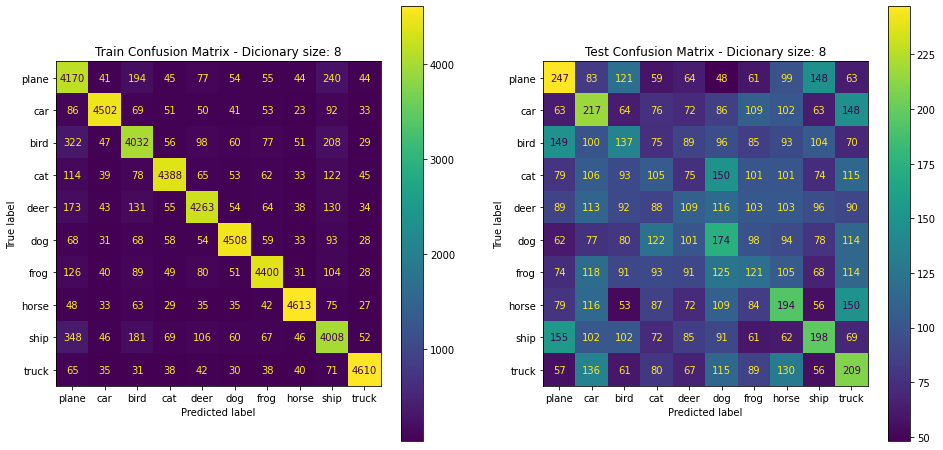

In [10]:
cm_train = sklearn.metrics.confusion_matrix(bof_y, predictions_train)
cm_test = sklearn.metrics.confusion_matrix(bof_y_test, predictions_test)

fig = plt.figure(figsize=(16,8))

ax = plt.subplot(1, 2, 1)
plt.title(f"Train Confusion Matrix - Dicionary size: {DICT_SIZE}")
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=classes)
disp = disp.plot(ax=ax)

ax = plt.subplot(1, 2, 2)
plt.title(f"Test Confusion Matrix - Dicionary size: {DICT_SIZE}")
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=classes)
disp = disp.plot(ax=ax)
plt.show()

## A classifier using ConvNet

### Create Dataloaders

In [11]:
BATCHSIZE = 128

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCHSIZE, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCHSIZE, shuffle=False, num_workers=2)

### Define Network Architecture

In [12]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1),
            nn.MaxPool2d(2),
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=5, stride=1),
            nn.MaxPool2d(2),
            nn.ReLU(True),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(800, 240),
            nn.ReLU(True),
            nn.Linear(240, 168),
            nn.ReLU(True),
            nn.Linear(168, NUM_CLASSES),
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, data):
        feature = self.feature(data)
        return self.classifier(feature)

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)
net = ConvNet().to(device)

cuda:0


### Train Network

In [13]:
NUM_EPOCHS = 50

loss_fn = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.005)

for epoch in range(NUM_EPOCHS):
    # Training
    net.train()
    loss_epoch_train = 0.0
    corrects_epoch_train = 0
    for X, y in trainloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        
        out = net(X)
        
        loss = loss_fn(out, y)
        loss.backward()
        optimizer.step()
        
        prob, pred = torch.max(out.data, 1)
        corrects_epoch_train += (pred == y.long()).sum().item()
        loss_epoch_train += loss.item()
    # Evaluation
    net.eval()
    loss_epoch_eval = 0.0
    corrects_epoch_eval = 0
    for X, y in testloader:
        X, y = X.to(device), y.to(device)
        
        with torch.no_grad():
            out = net(X)
            loss = loss_fn(out, y)
        
        prob, pred = torch.max(out.data, 1)
        corrects_epoch_eval += (pred == y.long()).sum().item()
        loss_epoch_eval += loss.item()
    
    loss_epoch_train /= len(trainloader)
    loss_epoch_eval /= len(testloader)
    acc_epoch_train = float(corrects_epoch_train)/len(trainloader.dataset)
    acc_epoch_eval = float(corrects_epoch_eval)/len(testloader.dataset)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}: train_loss={loss_epoch_train:.4f}, train_acc={acc_epoch_train:.4f}, test_loss={loss_epoch_eval:.4f}, test_acc={acc_epoch_eval:.4f}")

Epoch 1/50: train_loss=2.3009, train_acc=0.1038, test_loss=2.2974, test_acc=0.1259
Epoch 2/50: train_loss=2.2904, train_acc=0.1777, test_loss=2.2773, test_acc=0.1960
Epoch 3/50: train_loss=2.1950, train_acc=0.2262, test_loss=2.0576, test_acc=0.2664
Epoch 4/50: train_loss=1.9852, train_acc=0.2846, test_loss=1.9248, test_acc=0.3043
Epoch 5/50: train_loss=1.8795, train_acc=0.3197, test_loss=1.8116, test_acc=0.3408
Epoch 6/50: train_loss=1.7585, train_acc=0.3555, test_loss=1.7023, test_acc=0.3740
Epoch 7/50: train_loss=1.6650, train_acc=0.3874, test_loss=1.6354, test_acc=0.3968
Epoch 8/50: train_loss=1.6000, train_acc=0.4126, test_loss=1.5692, test_acc=0.4227
Epoch 9/50: train_loss=1.5554, train_acc=0.4301, test_loss=1.5265, test_acc=0.4354
Epoch 10/50: train_loss=1.5133, train_acc=0.4467, test_loss=1.4847, test_acc=0.4567
Epoch 11/50: train_loss=1.4711, train_acc=0.4624, test_loss=1.4394, test_acc=0.4727
Epoch 12/50: train_loss=1.4319, train_acc=0.4794, test_loss=1.4168, test_acc=0.4776
E

### Evaluate Model

#### Get Predictions and Show Train and Target Accuracy

In [14]:
def get_preds(net, dataloader):
    net.eval()
    preds = []
    gt = []
    for X, y in dataloader:
        X = X.to(device)
        
        with torch.no_grad():
            out = net(X)
        
        prob, pred = torch.max(out.data, 1)
        preds.extend(pred.cpu().numpy().tolist())
        gt.extend(y.numpy().tolist())
    return preds, gt

# Compute Metrics
preds_train, gt_train = get_preds(net, trainloader)
preds_test, gt_test = get_preds(net, testloader)
print("Accuracy Train", sklearn.metrics.accuracy_score(gt_train, preds_train))
print("Accuracy Test", sklearn.metrics.accuracy_score(gt_test, preds_test))

Accuracy Train 0.72374
Accuracy Test 0.6806


#### Plot Confusion Matrix

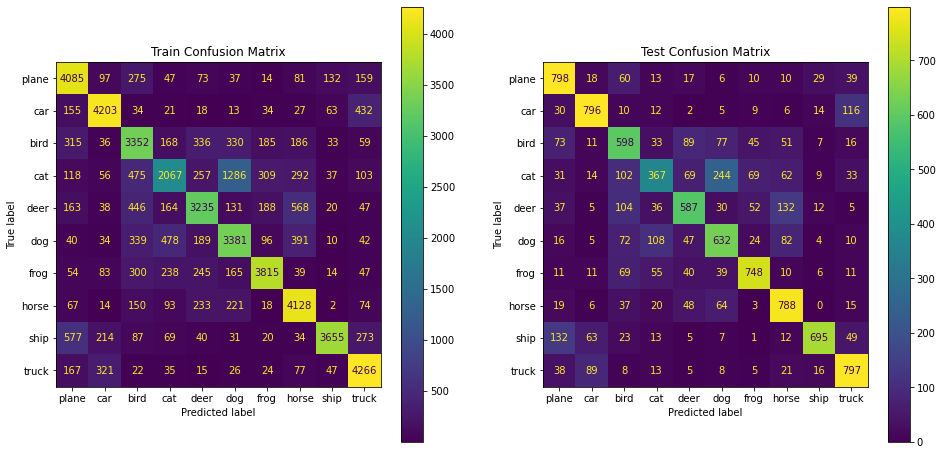

In [15]:
cm_train = sklearn.metrics.confusion_matrix(gt_train, preds_train)
cm_test = sklearn.metrics.confusion_matrix(gt_test, preds_test)

fig = plt.figure(figsize=(16,8))

ax = plt.subplot(1, 2, 1)
plt.title("Train Confusion Matrix")
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=classes)
disp = disp.plot(ax=ax)

ax = plt.subplot(1, 2, 2)
plt.title("Test Confusion Matrix")
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=classes)
disp = disp.plot(ax=ax)
plt.show()